In [ ]:
import rdkit.Chem as Chem
from rdkit.Chem import Draw, AllChem, PandasTools, rdFingerprintGenerator
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components
from scipy.stats import bootstrap
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [210]:
glycans = pd.read_csv('../data/Glycan-Structures-CFG611.txt', sep="\s")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
/var/folders/lg/qdb8l8gj3csbvxb_svgr1t0c0000gn/T/ipykernel_16897/2999785601.py:1: SyntaxWarning: invalid escape sequence '\s'
  glycans = pd.read_csv('../data/Glycan-Structures-CFG611.txt', sep="\s")
/var/folders/lg/qdb8l8gj3csbvxb_svgr1t0c0000gn/T/ipykernel_16897/2999785601.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  glycans = pd.read_csv('../data/Glycan-Structures-CFG611.txt', sep="\s")


In [211]:
glycans.head()

Name          IUPAC  \
0   CFG-007-Sp8      Gal(α-Sp8   
1   CFG-008-Sp8      Glc(α-Sp8   
2   CFG-009-Sp8      Man(α-Sp8   
3   CFG-010-Sp8   GalNAc(α-Sp8   
4  CFG-010-Sp15  GalNAc(α-Sp15   

                                              SMILES  
0  OC[C@@H](O1)[C@H](O)[C@H](O)[C@@H](O)[C@H]1-OC...  
1  OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H](O)[C@H]1-O...  
2  OC[C@@H](O1)[C@@H](O)[C@H](O)[C@H](O)[C@H]1-OC...  
3  OC[C@@H](O1)[C@H](O)[C@H](O)[C@@H](NC(=O)C)[C@...  
4  OC[C@@H](O1)[C@H](O)[C@H](O)[C@@H](NC(=O)C)[C@...

Code from Eric below:

"Here's a quick example of using it to convert SMILES strings into atom and bond lists for each molecule."

In [4]:
# iterate over the molecules
for index, row in glycans.iterrows():
    # convert the SMILES string into a RdKit molecule
    molecule = Chem.MolFromSmiles(row['SMILES'])
    if not molecule:
        print('SMILES not converted: {}, {}\n'.format(index, row['SMILES']))
        break

    print(row['Name'])
    # iterate over the atoms of the molecule
    for i, atom in enumerate(molecule.GetAtoms()):
        print('\t{}\t{}\t{}\t{}\t{}'.format(i, atom.GetSymbol(), atom.GetTotalNumHs(),
                                          atom.GetHybridization(), atom.GetChiralTag()
                                          )
        )


    # list the bonds in the molecule
    for bond in molecule.GetBonds():
        print('\t{}\t{}-{}'.format(bond.GetBondType(),
                                   bond.GetBeginAtomIdx(),
                                   bond.GetEndAtomIdx()
                                   )
              )

CFG-007-Sp8
	0	O	1	SP3	CHI_UNSPECIFIED
	1	C	2	SP3	CHI_UNSPECIFIED
	2	C	1	SP3	CHI_TETRAHEDRAL_CW
	3	O	0	SP3	CHI_UNSPECIFIED
	4	C	1	SP3	CHI_TETRAHEDRAL_CCW
	5	O	1	SP3	CHI_UNSPECIFIED
	6	C	1	SP3	CHI_TETRAHEDRAL_CCW
	7	O	1	SP3	CHI_UNSPECIFIED
	8	C	1	SP3	CHI_TETRAHEDRAL_CW
	9	O	1	SP3	CHI_UNSPECIFIED
	10	C	1	SP3	CHI_TETRAHEDRAL_CW
	11	O	0	SP3	CHI_UNSPECIFIED
	12	C	2	SP3	CHI_UNSPECIFIED
	13	C	2	SP3	CHI_UNSPECIFIED
	14	C	2	SP3	CHI_UNSPECIFIED
	15	N	1	SP2	CHI_UNSPECIFIED
	16	C	0	SP2	CHI_UNSPECIFIED
	17	O	0	SP2	CHI_UNSPECIFIED
	18	C	2	SP3	CHI_UNSPECIFIED
	19	C	2	SP3	CHI_UNSPECIFIED
	20	C	2	SP3	CHI_UNSPECIFIED
	21	O	0	SP3	CHI_UNSPECIFIED
	22	C	3	SP3	CHI_UNSPECIFIED
	SINGLE	0-1
	SINGLE	1-2
	SINGLE	2-3
	SINGLE	2-4
	SINGLE	4-5
	SINGLE	4-6
	SINGLE	6-7
	SINGLE	6-8
	SINGLE	8-9
	SINGLE	8-10
	SINGLE	10-11
	SINGLE	11-12
	SINGLE	12-13
	SINGLE	13-14
	SINGLE	14-15
	SINGLE	15-16
	DOUBLE	16-17
	SINGLE	16-18
	SINGLE	18-19
	SINGLE	19-20
	SINGLE	20-21
	SINGLE	21-22
	SINGLE	10-3
CFG-008-Sp8
	0	O	1	SP3	CHI_UNSPECIF

Display 2D physical structure visualization of the first n glycans. 
(Lots of general patterns/shapes that we could encode as features)

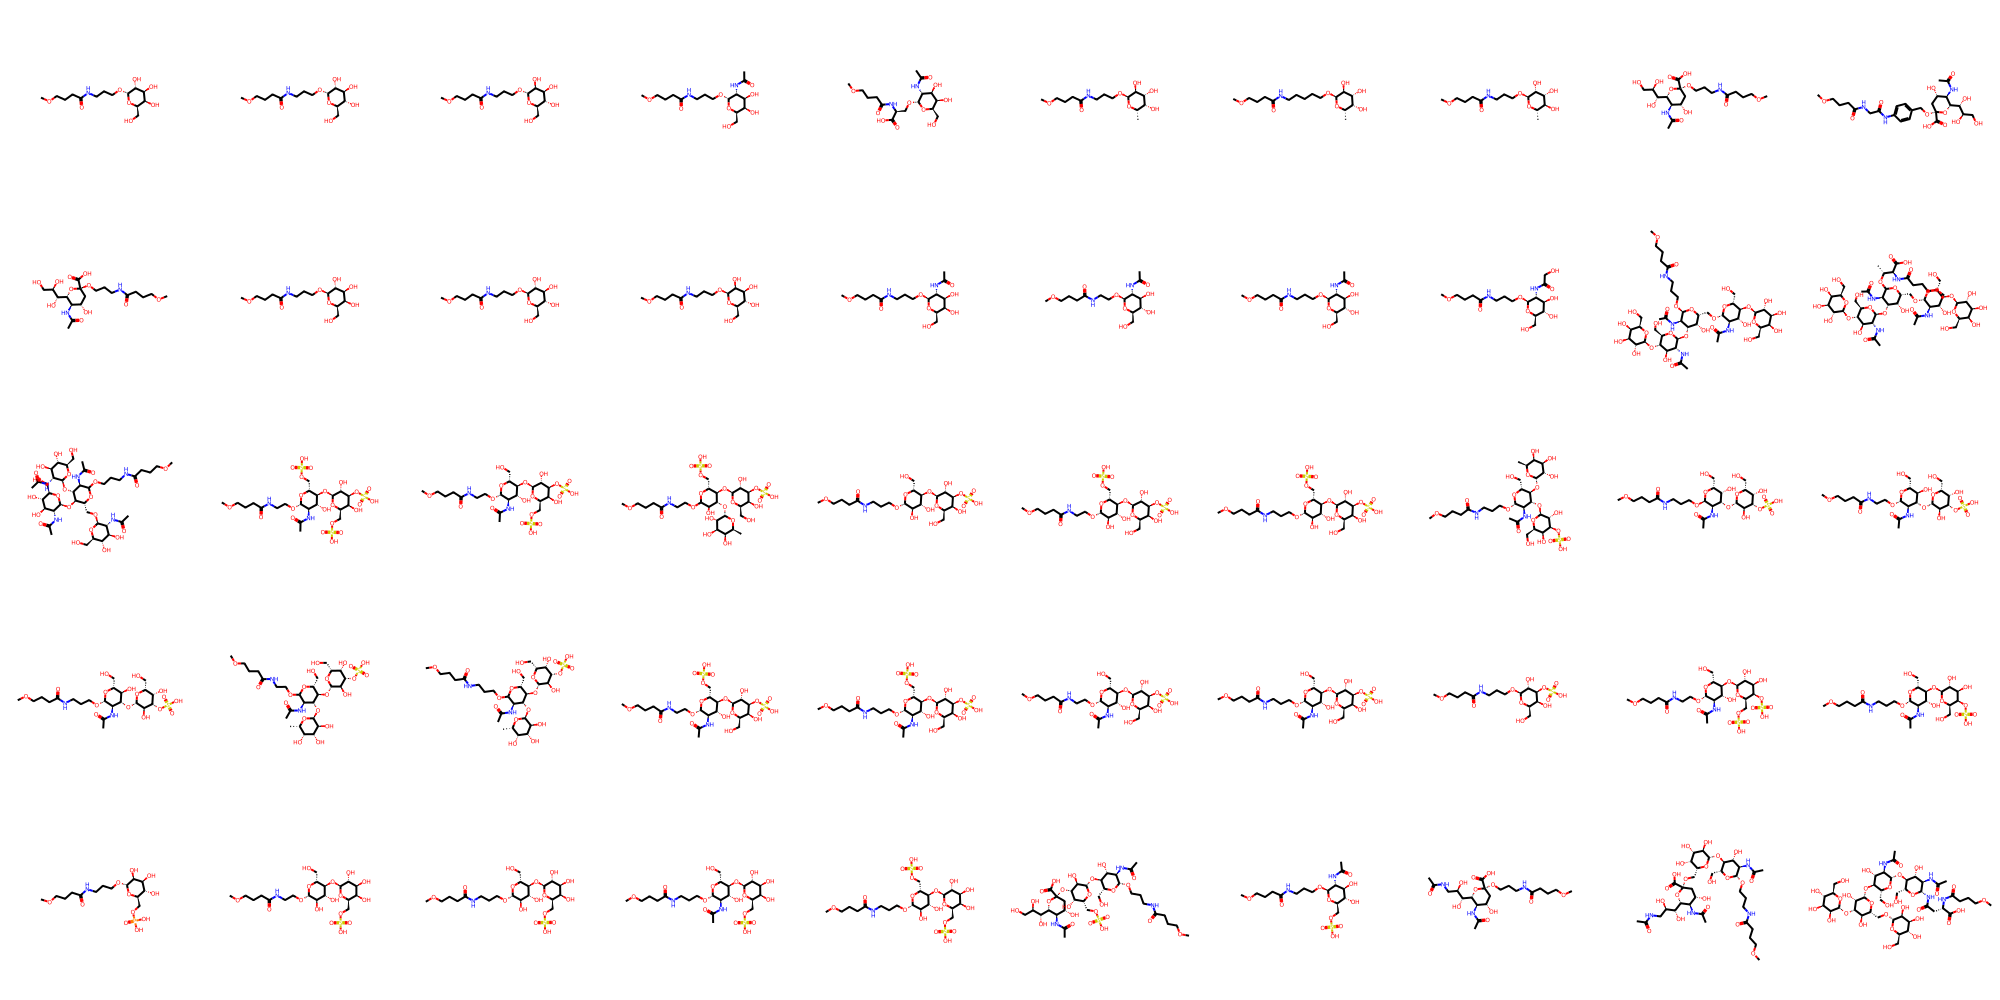

In [212]:
n = 50
first_n_smiles = glycans['SMILES'].tolist()[:n]
first_n_mols = [Chem.MolFromSmiles(smile) for smile in first_n_smiles]
Draw.MolsToGridImage(first_n_mols, molsPerRow=10, subImgSize=(200, 200))

Add these visualizations to our dataframe as a visual reference when comparing samples

In [213]:
PandasTools.RenderImagesInAllDataFrames(images=True)
PandasTools.AddMoleculeColumnToFrame(glycans, smilesCol='SMILES')

Name         IUPAC  \
0  CFG-007-Sp8     Gal(α-Sp8   
1  CFG-008-Sp8     Glc(α-Sp8   
2  CFG-009-Sp8     Man(α-Sp8   
3  CFG-010-Sp8  GalNAc(α-Sp8   

                                              SMILES  \
0  OC[C@@H](O1)[C@H](O)[C@H](O)[C@@H](O)[C@H]1-OC...   
1  OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H](O)[C@H]1-O...   
2  OC[C@@H](O1)[C@@H](O)[C@H](O)[C@H](O)[C@H]1-OC...   
3  OC[C@@H](O1)[C@H](O)[C@H](O)[C@@H](NC(=O)C)[C@...   

                                           ROMol  
0  <rdkit.Chem.rdchem.Mol object at 0x1448ddcb0>  
1  <rdkit.Chem.rdchem.Mol object at 0x169bad310>  
2  <rdkit.Chem.rdchem.Mol object at 0x169bad3f0>  
3  <rdkit.Chem.rdchem.Mol object at 0x169bad460>
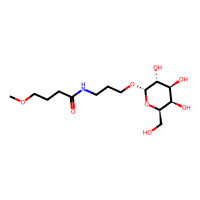
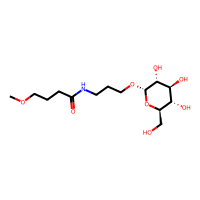
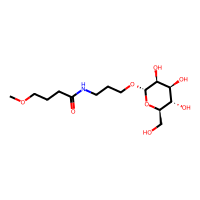
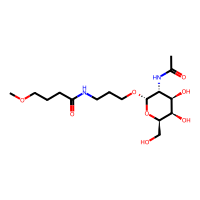

In [214]:
glycans.head(4)

Average amount of atoms in a glycan is about 90, so we should extend our radius as we have many subcomponents we can capture

In [215]:
glycans['num_atoms'] = glycans['SMILES'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
print(glycans['num_atoms'].describe())  # Get min, max, avg number of atoms

count    611.000000
mean      92.656301
std       69.881819
min       22.000000
25%       49.500000
50%       67.000000
75%      110.000000
max      499.000000
Name: num_atoms, dtype: float64


In [216]:
first_row = glycans.iloc[0]
smile = first_row['SMILES']
mol = Chem.MolFromSmiles(smile)

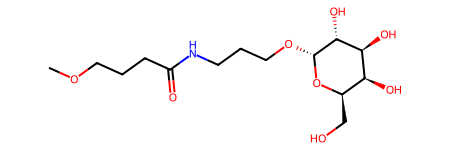

In [217]:
mol

In [218]:
kid_named_morgan_finger = rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=2048)

Since average bits per fingerprint of 2048 is very small relative wise for a raidus of 3 (we can set to a bit size of 1024 as we will have a sparse vector)

In [219]:
fp_arrays = glycans['SMILES'].apply(lambda x: kid_named_morgan_finger.GetFingerprint(Chem.MolFromSmiles(x)).ToBitString())
bit_counts = np.array([list(map(int, fp)) for fp in fp_arrays])
avg_active_bits = bit_counts.sum(axis=0).mean()

print(f"Average active bits per fingerprint: {avg_active_bits}")

Average active bits per fingerprint: 33.705078125


In [220]:
#kid_named_morgan_finger.GetFingerprint(mol): returns a bit vector of size fpSize
#kid_named_morgan_finger.GetCountFingerprint(mol): returns a count vector of size fpSize
#kid_named_morgan_finger.GetSparseFingerprint(mol): returns a sparse bit vector
#kid_named_morgan_finger.GetSparseCountFingerprint(mol): returns a sparse count vector
# these might be important for later use^^^ Read this: https://greglandrum.github.io/rdkit-blog/posts/2021-07-06-simulating-counts.html#:~:text=Bit%20vectors%20track%20whether%20or,of%20times%20each%20feature%20appears.

# play with these parameters. Will vary preformance and computational costs
radius = 3
fp_size = 1024

#The useChirality parameter in Morgan fingerprints determines whether chirality is considered when encoding a molecule.

#includeChirality=True = Differentiates between enantiomers (model will treat mirror-image molecules as different)
#includeChirality=False = Ignores chirality (model will treat mirror-image molecules as the same)


kid_named_morgan_finger = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fp_size, includeChirality=True)
bit_info={}
bfp = kid_named_morgan_finger.GetFingerprint(mol)
cfp = kid_named_morgan_finger.GetCountFingerprint(mol) # exact same result as GetFingerprint(mol) (binary) except we get count for each non zero

In [221]:
bit_counts = cfp.GetNonzeroElements()
print('amount of non zero:', len(bit_counts))
sorted_bits = sorted(bit_counts.items(), key=lambda x: x[1], reverse=True)
print(sorted_bits[:10])

amount of non zero: 56
[(80, 7), (807, 5), (1019, 5), (13, 3), (233, 3), (463, 3), (695, 2), (887, 2), (2, 1), (33, 1)]


[00:31:48] DEPRECATION WARNING: please use MorganGenerator


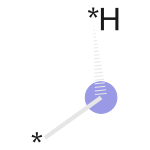

In [222]:
# For some reason GetFingerprint(mol) wont generate us a bit dict like we need for DrawMorganBit(), even though GetMorganFingerprintAsBitVect gives deprecated warning, use for now
bit={}
morganfp=AllChem.GetMorganFingerprintAsBitVect(mol,useChirality=True, radius=radius, nBits = fp_size, bitInfo=bit)
Draw.DrawMorganBit(mol, 80, bit)

In [223]:
# play with these parameters. Will vary preformance and computational costs
# https://github.com/rdkit/rdkit/discussions/5390
radius = 3
fp_size = 1024

def get_morgan_count_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return {f"mf_{i}": 0 for i in range(fp_size)} 

    cfp = kid_named_morgan_finger.GetCountFingerprint(mol)  
    bit_counts = cfp.GetNonzeroElements()  

    # Convert to a full 2048-length feature vector
    fingerprint_vector = {f"mf_{i}": bit_counts.get(i, 0) for i in range(fp_size)}
    return fingerprint_vector

fingerprint_df = glycans['SMILES'].apply(get_morgan_count_fingerprint).apply(pd.Series)
glycans = pd.concat([glycans, fingerprint_df], axis=1)

Name      IUPAC                                             SMILES  \
0  CFG-007-Sp8  Gal(α-Sp8  OC[C@@H](O1)[C@H](O)[C@H](O)[C@@H](O)[C@H]1-OC...   
1  CFG-008-Sp8  Glc(α-Sp8  OC[C@@H](O1)[C@@H](O)[C@H](O)[C@@H](O)[C@H]1-O...   
2  CFG-009-Sp8  Man(α-Sp8  OC[C@@H](O1)[C@@H](O)[C@H](O)[C@H](O)[C@H]1-OC...   

                                           ROMol  num_atoms  mf_0  mf_1  mf_2  \
0  <rdkit.Chem.rdchem.Mol object at 0x1448ddcb0>         23     0     0     1   
1  <rdkit.Chem.rdchem.Mol object at 0x169bad310>         23     0     0     1   
2  <rdkit.Chem.rdchem.Mol object at 0x169bad3f0>         23     0     0     1   

   mf_3  mf_4  ...  mf_1014  mf_1015  mf_1016  mf_1017  mf_1018  mf_1019  \
0     0     0  ...        0        0        0        0        0        5   
1     0     0  ...        0        0        0        0        0        5   
2     0     0  ...        0        0        0        0        0        5   

   mf_1020  mf_1021  mf_1022  mf_1023  
0        0        0        0        0  
1        0        0        0        0  
2        0        0        0        0  

[3 rows x 1029 columns]
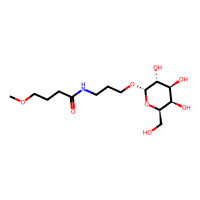
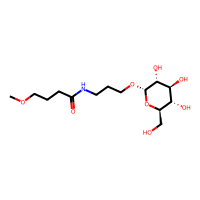
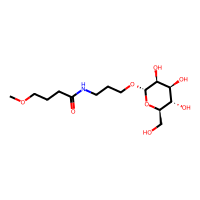

In [224]:
glycans.head(3)

In [225]:
feature_columns = [f'mf_{i}' for i in range(fp_size)] 
fingerprint_data = glycans[feature_columns]
feature_counts = fingerprint_data.sum(axis=0).sort_values(ascending=False)
print("Most common features by count:")
print(feature_counts.head(10)) 

Most common features by count:
mf_1019    17769
mf_807     13651
mf_80       6736
mf_233      6434
mf_463      6093
mf_695      4229
mf_893      3727
mf_656      3652
mf_897      3473
mf_650      3324
dtype: int64


GlyNet(monosaccharides, linkages) counts

Morgan fingerprints substructures of glycan and more generalized molecular representation. 


In [226]:
# matrix version of fingerprint features. Each row is a glycan, each column is a fingerprint component shape: (611, 2048)
finger_counts_matrix = fingerprint_df.values

# pdist calculates the euclidean distance between the combination of each glycan with every other glycan. Then squareform() turns this into a matrix representation where each row is a glycan and each column is the same list of glycans so we can have a comparison matrix. Shape: (611, 611)
dist_matrix = squareform(pdist(finger_counts_matrix, metric="euclidean"))

In [228]:
# bin edges
bin_edges = np.arange(0, np.max(dist_matrix) + 10, 10)  # Bins: 0-10, 10-20, ..., max
flattened_distances = dist_matrix[np.triu_indices_from(dist_matrix, k=1)]  # Ignore diagonal (self-distances)
hist_counts, _ = np.histogram(flattened_distances, bins=bin_edges)

for i in range(len(hist_counts)):
    print(f"Count of distances in range {bin_edges[i]} - {bin_edges[i+1]}: {hist_counts[i]}")


Count of distances in range 0.0 - 10.0: 5195
Count of distances in range 10.0 - 20.0: 58893
Count of distances in range 20.0 - 30.0: 33262
Count of distances in range 30.0 - 40.0: 20445
Count of distances in range 40.0 - 50.0: 13493
Count of distances in range 50.0 - 60.0: 10927
Count of distances in range 60.0 - 70.0: 10027
Count of distances in range 70.0 - 80.0: 8783
Count of distances in range 80.0 - 90.0: 6278
Count of distances in range 90.0 - 100.0: 4716
Count of distances in range 100.0 - 110.0: 2812
Count of distances in range 110.0 - 120.0: 1975
Count of distances in range 120.0 - 130.0: 1979
Count of distances in range 130.0 - 140.0: 1180
Count of distances in range 140.0 - 150.0: 879
Count of distances in range 150.0 - 160.0: 1138
Count of distances in range 160.0 - 170.0: 951
Count of distances in range 170.0 - 180.0: 842
Count of distances in range 180.0 - 190.0: 501
Count of distances in range 190.0 - 200.0: 464
Count of distances in range 200.0 - 210.0: 314
Count of dis

In [229]:
percentiles = np.percentile(flattened_distances, [10, 25, 50, 75, 90])
print('Total 611 glycans')
print(f"10th Percentile (~Top {int(611*0.10)}): {percentiles[0]}")
print(f"25th Percentile: (~Top {int(611*0.25)}): {percentiles[1]}")
print(f"50th Percentile (~Top {int(611*0.50)}) (Median): {percentiles[2]}")
print(f"75th Percentile: (~Top {int(611*0.75)}): {percentiles[3]}")
print(f"90th Percentile: (~Top {int(611*0.90)}): {percentiles[4]}")


Total 611 glycans
10th Percentile (~Top 61): 12.609520212918492
25th Percentile: (~Top 152): 16.97056274847714
50th Percentile (~Top 305) (Median): 27.874719729532707
75th Percentile: (~Top 458): 57.367238037053866
90th Percentile: (~Top 549): 90.71383576941281


In [230]:
# I dont like how this function works. If threshold is 10 for example will connect like so: 
# (connection, euc dist): (A-B, 5), (B-C, 7), (C-D, 8), (A-C, 15), (A-D, 25).
# This will link All A, B, C, D into a group as there are indirect connections as there exist connections under 10. Even though A-D and A-C has a connection over 10
adjacency_matrix = (dist_matrix <= 10).astype(int)
n_groups, labels = connected_components(csgraph=adjacency_matrix, directed=False)

In [242]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

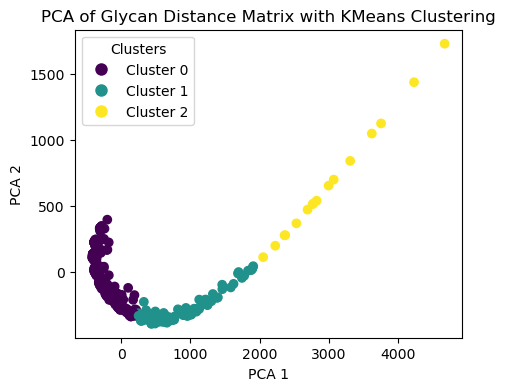

In [231]:
n_clusters = 3

kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(dist_matrix)

pca = PCA(n_components=2)
pca_components = pca.fit_transform(dist_matrix)
plt.figure(figsize=(5, 4))
#plt.scatter(x=pca_components[:, 0], y=pca_components[:, 1], hue=labels, palette='Set1', s=100, marker='o', edgecolor='black')
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis')
plt.title('PCA of Glycan Distance Matrix with KMeans Clustering')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')


legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(n_clusters)]
plt.legend(handles=legend_handles, labels=legend_labels, title="Clusters")
plt.show()

In [232]:
np.unique(labels, return_counts=True)

(array([0, 1, 2], dtype=int32), array([486, 109,  16]))

In [234]:
glycans['Cluster_Label'] = labels

In [235]:
unique_clusters = np.unique(labels)


avg_distances = {}
for i, cluster_1 in enumerate(unique_clusters):
    for cluster_2 in unique_clusters[i:]: 
        indices_1 = np.where(labels == cluster_1)[0]
        indices_2 = np.where(labels == cluster_2)[0]
        sub_matrix = dist_matrix[indices_1, :][:, indices_2]
        avg_distance = np.mean(sub_matrix)
        avg_distances[(cluster_1, cluster_2)] = avg_distance


for pair, dist in avg_distances.items():
    print(f"Avg Euclidean distance between Cluster {pair[0]} and Cluster {pair[1]}: {dist:.4f}")

Avg Euclidean distance between Cluster 0 and Cluster 0: 21.8520
Avg Euclidean distance between Cluster 0 and Cluster 1: 70.1332
Avg Euclidean distance between Cluster 0 and Cluster 2: 170.0848
Avg Euclidean distance between Cluster 1 and Cluster 1: 35.4633
Avg Euclidean distance between Cluster 1 and Cluster 2: 107.0244
Avg Euclidean distance between Cluster 2 and Cluster 2: 43.6551


Adding rdkit glycan features based on SMILES to check if visible diff between the clusters

In [236]:
from rdkit.Chem import Lipinski
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import GraphDescriptors

In [237]:
# Number of heavy (non-hydrogen) atoms
glycans['num_heavy_atoms'] = glycans['SMILES'].apply(lambda x: Chem.MolFromSmiles(x).GetNumHeavyAtoms())

# Number of rotatable bonds (affects molecular flexibility)
glycans['num_rotatable_bonds'] = glycans['SMILES'].apply(lambda x: Lipinski.NumRotatableBonds(Chem.MolFromSmiles(x)))

# Number of rings
glycans['num_rings'] = glycans['SMILES'].apply(lambda x: rdMolDescriptors.CalcNumRings(Chem.MolFromSmiles(x)))

# Number of aromatic rings
glycans['num_aromatic_rings'] = glycans['SMILES'].apply(lambda x: rdMolDescriptors.CalcNumAromaticRings(Chem.MolFromSmiles(x)))

# Molecular weight (Da)
glycans['mol_weight'] = glycans['SMILES'].apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))

# Molecular complexity (higher for more branched structures)
glycans['complexity'] = glycans['SMILES'].apply(lambda x: Descriptors.FractionCSP3(Chem.MolFromSmiles(x)))

# Topological polar surface area (TPSA) - related to solubility & permeability
glycans['tpsa'] = glycans['SMILES'].apply(lambda x: Descriptors.TPSA(Chem.MolFromSmiles(x)))

# Number of stereocenters (chiral centers)
glycans['num_stereocenters'] = glycans['SMILES'].apply(lambda x: len(Chem.FindMolChiralCenters(Chem.MolFromSmiles(x))))

# Hydrogen bond donors (HBD) and acceptors (HBA)
glycans['hbd'] = glycans['SMILES'].apply(lambda x: Lipinski.NumHDonors(Chem.MolFromSmiles(x)))
glycans['hba'] = glycans['SMILES'].apply(lambda x: Lipinski.NumHAcceptors(Chem.MolFromSmiles(x)))

# Presence of hydroxyl (-OH) groups (important for glycans)
glycans['num_oh_groups'] = glycans['SMILES'].apply(lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmarts('[OH]'))))

# Presence of ether (-O-) groups
glycans['num_ether_groups'] = glycans['SMILES'].apply(lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmarts('COC'))))

# Presence of carboxyl (-COOH) groups
glycans['num_carboxyl_groups'] = glycans['SMILES'].apply(lambda x: len(Chem.MolFromSmiles(x).GetSubstructMatches(Chem.MolFromSmarts('C(=O)[O;H1]'))))

# Molecular connectivity index (higher = more connected structure)
glycans['molecular_connectivity'] = glycans['SMILES'].apply(lambda x: GraphDescriptors.BalabanJ(Chem.MolFromSmiles(x)))

# Bertz Complexity (molecular graph complexity measure)
glycans['bertz_complexity'] = glycans['SMILES'].apply(lambda x: Descriptors.BertzCT(Chem.MolFromSmiles(x)))

# LogP (Hydrophobicity, affects protein interactions)
glycans['logP'] = glycans['SMILES'].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))

# Formal charge
glycans['formal_charge'] = glycans['SMILES'].apply(lambda x: Chem.GetFormalCharge(Chem.MolFromSmiles(x)))

# Number of oxygen atoms
glycans['num_oxygen'] = glycans['SMILES'].apply(lambda x: sum(1 for atom in Chem.MolFromSmiles(x).GetAtoms() if atom.GetSymbol() == 'O'))

# Number of carbon atoms
glycans['num_carbon'] = glycans['SMILES'].apply(lambda x: sum(1 for atom in Chem.MolFromSmiles(x).GetAtoms() if atom.GetSymbol() == 'C'))

Name      IUPAC                                             SMILES  \
0  CFG-007-Sp8  Gal(α-Sp8  OC[C@@H](O1)[C@H](O)[C@H](O)[C@@H](O)[C@H]1-OC...   

                                           ROMol  num_atoms  mf_0  mf_1  mf_2  \
0  <rdkit.Chem.rdchem.Mol object at 0x1448ddcb0>         23     0     0     1   

   mf_3  mf_4  ...  hba  num_oh_groups  num_ether_groups  num_carboxyl_groups  \
0     0     0  ...    8              4                 3                    0   

   molecular_connectivity  bertz_complexity    logP  formal_charge  \
0                2.181722        340.738956 -2.2642              0   

   num_oxygen  num_carbon  
0           8          14  

[1 rows x 1049 columns]
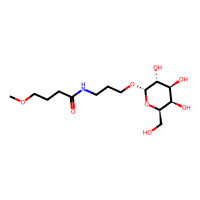

In [239]:
glycans.head(1)

In [240]:
glycans.groupby('Cluster_Label')

In [243]:
glycans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Columns: 1049 entries, Name to num_carbon
dtypes: float64(6), int32(1), int64(1038), object(4)
memory usage: 4.9+ MB


In [266]:
numeric_cols = [col for col in glycans.columns if glycans[col].dtype in ['int64', 'float64', 'int32'] and not col.startswith('mf_')]

cluster_summary = glycans[numeric_cols].groupby('Cluster_Label').agg(['mean', 'std', 'min', 'max'])

min_size = min(np.unique(glycans['Cluster_Label'], return_counts=True)[1])
# Sample each cluster to min_size
balanced_samples = glycans.groupby('Cluster_Label', group_keys=False).apply(lambda x: x.sample(n=min_size, random_state=42))
# Compute summary stats on balanced dataset
balanced_summary = balanced_samples[numeric_cols].groupby('Cluster_Label').agg(['mean', 'std', 'min', 'max'])

def bootstrap_stat(data, n_resamples=100):
    return bootstrap((data,), np.mean, n_resamples=n_resamples, random_state=42).confidence_interval

# Apply bootstrap confidence intervals
bootstrap_results = glycans.groupby('Cluster_Label')[numeric_cols].apply(lambda x: x.apply(lambda col: bootstrap_stat(col.values)))


/var/folders/lg/qdb8l8gj3csbvxb_svgr1t0c0000gn/T/ipykernel_16897/4267666000.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_samples = glycans.groupby('Cluster_Label', group_keys=False).apply(lambda x: x.sample(n=min_size, random_state=42))
/opt/miniconda3/envs/glycan-env/lib/python3.13/site-packages/scipy/stats/_resampling.py:147: RuntimeWarning: invalid value encountered in scalar divide
  a_hat = 1/6 * sum(nums) / sum(dens)**(3/2)
/opt/miniconda3/envs/glycan-env/lib/python3.13/site-packages/scipy/_lib/_util.py:440: DegenerateDataWarning: The BCa confidence interval cannot be calculated. This problem is known to occur when the distribution is degenerate or the statistic is np.min.
 

In [250]:
print(cluster_summary.to_string())

                num_atoms                      num_heavy_atoms                      num_rotatable_bonds                      num_rings                   num_aromatic_rings                     mol_weight                                 complexity                                       tpsa                               num_stereocenters                            hbd                             hba                      num_oh_groups                    num_ether_groups                   num_carboxyl_groups                   molecular_connectivity                               bertz_complexity                                               logP                              formal_charge               num_oxygen                       num_carbon                     
                     mean        std  min  max            mean        std  min  max                mean        std min  max       mean       std min max               mean       std min max         mean         std       min      

In [ ]:
print(balanced_summary.to_string())

              num_atoms                      num_heavy_atoms                      num_rotatable_bonds                     num_rings                   num_aromatic_rings                 mol_weight                                 complexity                                       tpsa                               num_stereocenters                          hbd                           hba                      num_oh_groups                    num_ether_groups                   num_carboxyl_groups                   molecular_connectivity                               bertz_complexity                                               logP                              formal_charge              num_oxygen                      num_carbon                     
                   mean        std  min  max            mean        std  min  max                mean        std min  max      mean       std min max               mean   std min max         mean         std       min       max       mean     

In [267]:
# bootstrap has confidence intervals so each cluster label has two rows (min, max)
print(bootstrap_results.to_string())

                  num_atoms  Cluster_Label  num_heavy_atoms  num_rotatable_bonds  num_rings  num_aromatic_rings   mol_weight  complexity         tpsa  num_stereocenters        hbd         hba  num_oh_groups  num_ether_groups  num_carboxyl_groups  molecular_connectivity  bertz_complexity       logP  formal_charge  num_oxygen  num_carbon
Cluster_Label                                                                                                                                                                                                                                                                                                                                    
0             0   61.688747            NaN        61.688747            20.790720   3.784537            0.002724   906.356527    0.898522   403.430332          19.371308  13.977366   22.867946      11.108891          8.397458             0.516461                1.666435       1459.078154  -8.978073            NaN   23.50986

# Cluster label (3) K-means split summary analysis

Firstly, these results should be observed with caution as we have a huge uneven distribution of classes between the 3 classes ((array([0, 1, 2], dtype=int32), array([486, 109,  16]))).

I tried to combat this uneven distr by using random samplying based on the min count (16) and also bootstrapping.

With these assumptions taken into account there is a noticable difference/pattern between the classes. It seems like cluster zero has all of the smaller glycans, cluster 1 has medium glycans, and cluster 2 has the largest glycans. This is apparent through the calculcated aggregate distribtuoins of num_atoms, num_heavy_atoms, num_rotatable_bonds, num_rings, mol_weight, etc....

Since these clusters are based on calculated euclidean distances, this makes sense as the larger the glycan, the more morgan fingerprint subcomponents it will have and thus the higher euclidean distance value it will have with other glycans. 

* Note: Chat-GPT was used to generate some of the code blocks. *